<a href="https://colab.research.google.com/github/woodword-0/ML-Projects/blob/main/TimeSeriesModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/W_Corporate.csv')
#df = df[5::6] #index starting from 5 taking every 6th record
date_time = pd.to_datetime(df.pop('Date'), format = '%Y-%m-%d')

In [ ]:
df.shape

(143, 6)

In [ ]:
df.head()

,Unnamed: 0,Weekly_Sales,Weekly_Sales_log,minMax_WeeklySales,minMax_log,log_minMax
0,0,4.395632e+07,17.598707,0.268822,0.238089,0.326115
1,1,4.390070e+07,17.597441,0.266719,0.236430,0.323775
2,2,4.396829e+07,17.598979,0.269274,0.238445,0.326618
3,3,4.040934e+07,17.514572,0.134733,0.126397,0.170631
4,4,4.252274e+07,17.565550,0.214627,0.194437,0.264839


Looking at some features

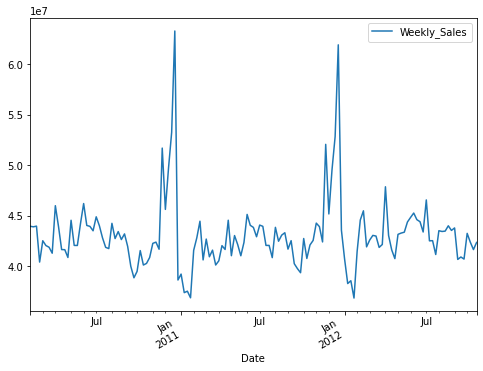

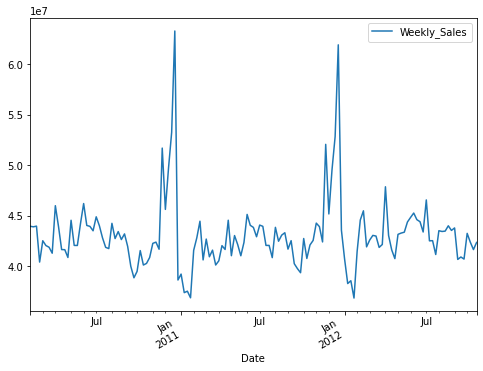

In [ ]:
plot_cols = ['Weekly_Sales']
plot_features = df[plot_cols]
plot_features.index = date_time
_=plot_features.plot(subplots = True)

plot_features = df[plot_cols]#[:480]
plot_features.index = date_time#[:480]
_= plot_features.plot(subplots = True)


In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,143.0,7.100000e+01,4.142463e+01,0.000000e+00,3.550000e+01,7.100000e+01,1.065000e+02,1.420000e+02
Weekly_Sales,143.0,4.306387e+07,3.532692e+06,3.684533e+07,4.155836e+07,4.255290e+07,4.395299e+07,6.329779e+07
Weekly_Sales_log,143.0,1.757523e+01,7.512603e-02,1.742224e+01,1.754261e+01,1.756626e+01,1.759863e+01,1.796336e+01
minMax_WeeklySales,143.0,2.350838e-01,1.335487e-01,0.000000e+00,1.781699e-01,2.157672e-01,2.686956e-01,1.000000e+00
minMax_log,143.0,2.061361e-01,9.712574e-02,0.000000e+00,1.639622e-01,1.953754e-01,2.379893e-01,6.931472e-01
log_minMax,143.0,2.827358e-01,1.388339e-01,0.000000e+00,2.224451e-01,2.661495e-01,3.259744e-01,1.000000e+00


In [ ]:
max(df.Weekly_Sales)

63297789.73790484

I will use the Fourier Transform to pick out the most important time frequencies for our data.

In [ ]:

fft = tf.signal.rfft(df['Weekly_Sales'])
f_per_dataset = np.arange(0,len(fft)) #72

n_samples_h = len(df['Weekly_Sales']) #143
weeks_per_year = 52
weeks_per_dataset = n_samples_h/weeks_per_year

f_per_year = f_per_dataset/weeks_per_year
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0,37868291)
plt.xlim([1, max(plt.xlim())])
plt.xticks([0.1,10], labels = ['1/Year', '1/week'])
_= plt.xlabel('Frequency(log scale)')

In [ ]:
fft = tf.signal.rfft(df['Weekly_Sales'])


In [ ]:
len(date_time)

143

In [ ]:
143/2

71.5

In [ ]:
column_indices = {name:i for i, name in enumerate(df.columns)}
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

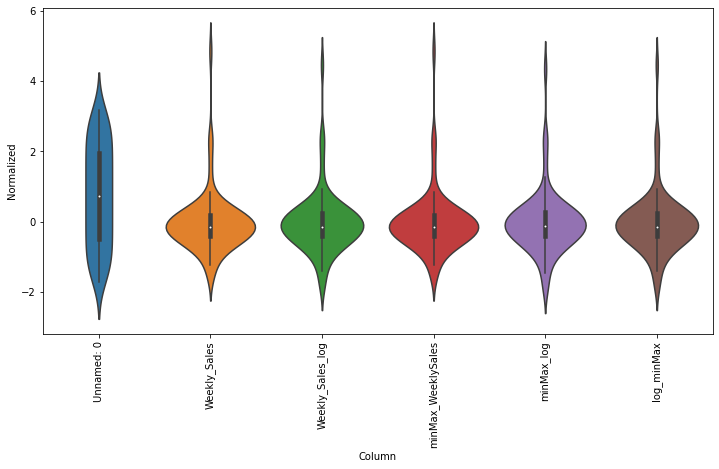

In [ ]:
df_std = (df - train_mean)/train_std
df_std = df_std.melt(var_name = 'Column', value_name = 'Normalized')
plt.figure(figsize = (12,6))
ax = sns.violinplot(x ='Column', y = 'Normalized', data = df_std)
_= ax.set_xticklabels(df.keys(), rotation  = 90)

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
# #Makes a prediction 13 weeks into the future using 13 weeks of history
w1 = WindowGenerator(input_width = 13 ,label_width = 1, shift=13, label_columns= ['Weekly_Sales'] )
w1
#Makes a prediction 13 weeks into the future using 13 weeks of history
# w1 = WindowGenerator(input_width = 20 ,label_width = 1, shift=10, label_columns= ['Weekly_Sales'] )
# w1

Total window size: 26
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Label indices: [25]
Label column name(s): ['Weekly_Sales']

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :] #slice features 0 to input width 13 here
  labels = features[:, self.labels_slice, :]#slice total window size - label width 25 here (26 - 1)
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
w1.total_window_size

26

In [ ]:
train_df.shape

(100, 6)

In [ ]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[w1.total_window_size:2*w1.total_window_size]),
                           np.array(train_df[2*w1.total_window_size:3*w1.total_window_size])])


example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')
#takes a batch of 3, 26-timestep windows with 6 features at
#each time step splits them into a batch of 13-timestep, 6 feature inputs
#and a 1-timestep 1-feature label 

All shapes are: (batch, time, features)
Window shape: (3, 26, 6)
Inputs shape: (3, 13, 6)
labels shape: (3, 1, 1)


In [ ]:
w1.example = example_inputs, example_labels

In [ ]:
def plot(self, model=None, plot_col='Weekly_Sales', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [w]')

WindowGenerator.plot = plot

In [ ]:
w1.plot()


In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,) #batch size 32

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset
# takes a time series data set and turns it into a data set
# of (input_window, label_window) pairs 

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
# Each element is an (inputs, label) pair
w1.train.element_spec

In [ ]:
#iterating over the dataset yields concrete batches
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Model which predicts a single feature's values


In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Weekly_Sales'])
single_step_window
#window object creates datasets from train, val and test
#allowing us to easily iterate over batches of data

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Weekly_Sales']

In [ ]:
#build a performance baseline as a point of comparison with
#later more complicated models
class Baseline(tf.keras.Model):
  def __init__(self, label_index = None):
    super().__init__()
    self.label_index  = label_index
  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:,:,self.label_index]
    return result[:,:, tf.newaxis]


In [ ]:
#Instantiate and evaluate this model
baseline = Baseline(label_index = column_indices['Weekly_Sales'])

baseline.compile(loss = tf.losses.MeanSquaredError(), 
                 metrics = [tf.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose = 0)
                

1/1 [==============================] - 0s 184ms/step - loss: 5540121935872.0000 - mean_absolute_error: 1693351.0000 - root_mean_squared_error: 2353746.2500


In [ ]:
wide_window = WindowGenerator(
    input_width=13, label_width=13, shift=1,
    label_columns=['Weekly_Sales'])

wide_window

Total window size: 14
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Label column name(s): ['Weekly_Sales']

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 13, 6)
Output shape: (32, 13, 1)


In [ ]:
wide_window.plot(baseline)


Blue inputs show sales at each time step
Green labels show the target predicted values
Orange values are the models predictions for each output step perfect predictions should align with th green labels

Linear Model

In [ ]:
#dense layer with no activation is a linear transformation. Layer only transforms the last 
#axis of the data from (batch, time, inputs) to (batch, time, inputs) it is applied
#independently to every item across the batch and time axes
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 6)
Output shape: (32, 1, 1)


In [ ]:
#Since we are training many models, we can package the training
#procedure into a function
MAX_EPOCHS = 20
def compile_and_fit(model, window, patience = 2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                     patience = patience, mode = 'min')
  model.compile(loss = tf.losses.MeanSquaredError(), 
                 metrics = [tf.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()]) 
  history = model.fit(window.train, epochs = MAX_EPOCHS, 
                      validation_data = window.val, 
                      callbacks = [early_stopping]) 
  return history

In [ ]:
#train the model and evaluate its performance
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose = 1)

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

In [ ]:
wide_window.plot(linear)

Dense Model

In [ ]:
#layers weights weight assigned to each input
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

In [ ]:
CONV_WIDTH = 13
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Weekly_Sales'])

conv_window

In [ ]:
conv_window.plot()
plt.title("Given 13w as input, predict 1w into the future.")

Multi-Step Dense

In [ ]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

In [ ]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=1)

In [ ]:
conv_window.plot(multi_step_dense)

In [ ]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Multi-Step CNN

A convolutional layer also takes multiple time steps as input to each prediction. The flattening layer and the dense layer are replaced by the Conv1D layer. No need for a reshape layer  because teh convolution layer keeps the time axis in its output.

In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [ ]:
#Run on the example batch
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

In [ ]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

In [ ]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Output is shorter than the input. To make the training or plotting work, labels and prediction must have the same length. We will build a window generator for this. It produces a few extra time input steps so the label and prediction lengths match.

In [ ]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Weekly_Sales'])

wide_conv_window

In [ ]:
print('Wide conv window')
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

In [ ]:
wide_conv_window.plot(conv_model)

Recurrent Neural Network (RNN) Long Short Term Memory (LSTM)

In [ ]:
lstm_model = tf.keras.models.Sequential([
   #Shape [batch, time, features] => [batch, time, LSTM units] 
    tf.keras.layers.LSTM(32, return_sequences = True), 
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)                                  
])

In [ ]:
print('Input Shape:',  wide_window.example[0].shape)
print('Output Shape:', lstm_model(wide_window.example[0]).shape)

In [ ]:
history = compile_and_fit(lstm_model, wide_window)
IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose = 1)

In [ ]:
wide_window.plot(lstm_model)

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Weekly_Sales, normalized]')
plt.bar(x - 0.17, val_mae, width, label = 'Validation')
plt.bar(x + 0.17, test_mae, width, label = 'Test')
plt.xticks(ticks = x, labels = performance.keys(), rotation = 45)
_= plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:12s}:{value[1]:0.4f}')